# Linear regression exercises

Credits: Matthew Graham, Pavlos Protopapas

This notebook provides exercises on linear regression. 

First we need to do some Python setup.

In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
sns.set(style="ticks")
%matplotlib inline

## Load and Explore Data

For these exercises, we're going to use a data set of galaxies with known (spectroscopically confirmed) redshifts and SDSS magnitudes. We're interested in determining the redshift of a galaxy from its colors (photometric redshift).
First we will load the data and have a look at it. The data can be downloaded from: <a href="http://www.astro.caltech.edu/~mjg/sdss_gal.csv.gz">http://www.astro.caltech.edu/~mjg/sdss_gal.csv.gz</a>

Note that you will need to uncompress the file before using it.

In [2]:
sdss_gal_df = pd.read_csv('sdss_gal.csv', low_memory=False)

In [3]:
sdss_gal_df.head()

,u-g,g-r,r-i,i-z,redshift
0,1.88235,0.95459,0.44631,0.32659,0.091214
1,1.97871,0.95931,0.46358,0.32285,0.117409
2,1.84007,0.92670,0.40268,0.32295,0.091852
3,1.89717,1.09666,0.47545,0.34684,0.153276
4,0.98144,0.38145,0.34404,0.04365,0.090731


In [4]:
sdss_gal_df.shape

(1841297, 5)

In [5]:
sdss_gal_df.columns

Index([u'u-g', u'g-r', u'r-i', u'i-z', u'redshift'], dtype='object')

We'll plot a random subsample of the data to get an idea of what it looks like.

In [6]:
sdss_gal_sample = sdss_gal_df.sample(n=1000, random_state=0)
redshift = sdss_gal_sample['redshift'].values
gr = sdss_gal_sample['g-r'].values

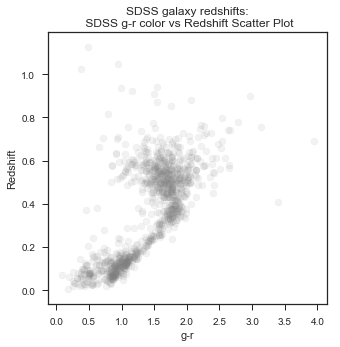

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(gr, redshift, color='gray', alpha=0.1)

ax.set_xlabel('g-r')
ax.set_ylabel('Redshift')
ax.set_title('SDSS galaxy redshifts:\n SDSS g-r color vs Redshift Scatter Plot')

plt.show()

---

## The syntax of a regressor

Scikit-learn models have a fixed syntax so it is the same for a simple linear regression operation as it is for something much more complex such as random forest. The specific model is represented as a class with model parameters defined in the class constructor:

In [ ]:
class sklearn.linear_model.LinearRegression(
    fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

The class will also have a <i>fit</i> method for fitting (training) the model which takes the data (X) as a Numpy array of shape [n_samples, n_features] and the response values (y) as a Numpy array of shape [n_samples, n_responses]:

In [ ]:
def fit(X, y):
    ...

---

## Modeling the Data

We're going to use train_test_split method to create our training and test data sets for a random subsample. We'll set the test set to be half the size of the training set:

In [8]:
sdss_gal_sample = sdss_gal_df.sample(n=1000, random_state=0)

y = sdss_gal_sample['redshift'].values
X = sdss_gal_sample['g-r'].values

X_train, X_test, y_train, y_test = train_test_split(X.reshape((len(X), 1)), y, test_size=0.33, random_state=0)

Now we define our basic linear regressor and fit it to the data. You can confirm that the values of the slope and intercept are what you would expect from a MSE loss function.

In [9]:
regression = LinearRegression(fit_intercept=True)
regression.fit(X_train, y_train)

regression_line = lambda x: regression.intercept_ + regression.coef_ * x
print 'The equation of the regression line is: {} + {} * x'.format(regression.intercept_, regression.coef_[0])

The equation of the regression line is: -0.0610563596323 + 0.304723028534 * x


And what does the regression line look like with the data:

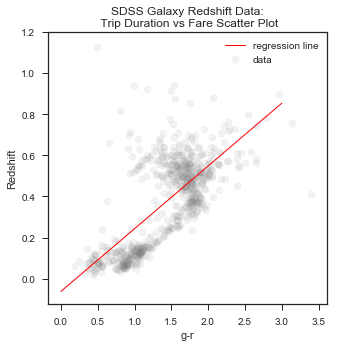

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

x_vals = np.linspace(0, 3, 100)
ax.plot(x_vals, regression_line(x_vals), color='red', linewidth=1.0, label='regression line')
ax.scatter(X_train, y_train, color='gray', alpha=0.1, label='data')


ax.set_xlabel('g-r')
ax.set_ylabel('Redshift')
ax.set_title('SDSS Galaxy Redshift Data:\n Trip Duration vs Fare Scatter Plot')
ax.legend(loc='best')

plt.show()

---

## Evaluate and Interpret the Model

Let's have a bit more of a look at the linear model we've fitted.

### 1. Train vs Test Error

Firstly how the MSE values look for the training and the test data sets:

In [11]:
train_MSE = np.mean((y_train - regression.predict(X_train))**2)
test_MSE = np.mean((y_test - regression.predict(X_test))**2)
print 'The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE)

The train MSE is 0.0232771488426, the test MSE is 0.0257204499348


### 2. Uncertainty in the Model Parameter Estimates

Now we're going to generate a whole load of random subsamples, fit these, and look at the distributions of the model parameters:

In [12]:
def find_regression_params(regression_model, samples):
    sdss_gal_sample = sdss_gal_df.sample(n=samples)

    y = sdss_gal_sample['redshift'].values
    X = sdss_gal_sample['g-r'].values

    X_train, X_test, y_train, y_test = train_test_split(X.reshape((len(X), 1)), y, test_size=0.33, random_state=0)

    regression_model.fit(X_train, y_train)
    
    return regression_model.intercept_, regression_model.coef_[0]

In [13]:
regression_model = LinearRegression(fit_intercept=True)

total_draws = 500
samples = 1000
regression_params = []

for i in range(total_draws):
    if i % 10 == 0:
        out = i * 1. / total_draws * 100
        sys.stdout.write("\r%d%%" % out)
        sys.stdout.flush()
        
    regression_params.append(find_regression_params(regression_model, samples))
    
sys.stdout.write("\r%d%%" % 100)
regression_params = np.array(regression_params)

100%

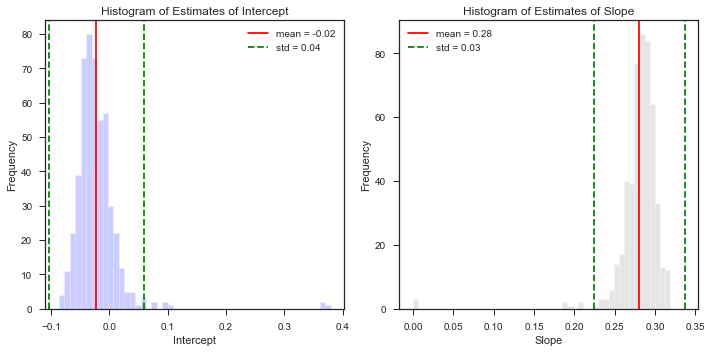

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].hist(regression_params[:, 0], bins=50, color='blue', edgecolor='white', linewidth=1, alpha=0.2)
ax[0].axvline(x=regression_params[:, 0].mean(), color='red', label='mean = {0:.2f}'.format(regression_params[:, 0].mean()))
ax[0].axvline(x=regression_params[:, 0].mean() - 2 * regression_params[:, 0].std(), color='green', linestyle='--', label='std = {0:.2f}'.format(regression_params[:, 0].std()))
ax[0].axvline(x=regression_params[:, 0].mean() + 2 * regression_params[:, 0].std(), color='green', linestyle='--')

ax[0].set_xlabel('Intercept')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Estimates of Intercept')
ax[0].legend(loc='best')


ax[1].hist(regression_params[:, 1], bins=50, color='gray', edgecolor='white', linewidth=1, alpha=0.2)
ax[1].axvline(x=regression_params[:, 1].mean(), color='red', label='mean = {0:.2f}'.format(regression_params[:, 1].mean()))
ax[1].axvline(x=regression_params[:, 1].mean() - 2 * regression_params[:, 1].std(), color='green', linestyle='--', label='std = {0:.2f}'.format(regression_params[:, 1].std()))
ax[1].axvline(x=regression_params[:, 1].mean() + 2 * regression_params[:, 1].std(), color='green', linestyle='--')

ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Estimates of Slope')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

### 3. The Effect of Sample Size on Uncertainty

We can also look at what the effect of sample size is on the model parameters:

In [15]:
regression_model = LinearRegression(fit_intercept=True)

def compute_SE(total_draws, samples, regression_model):

    regression_params = []

    for i in range(total_draws):
        regression_params.append(find_regression_params(regression_model, samples))

    regression_params = np.array(regression_params)
    return np.std(regression_params[:, 0]), np.std(regression_params[:, 1])

total_draws = 100
samples = range(100, 10001, 900)
ses = []

for i in range(len(samples)):
    out = i * 1. / len(samples) * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()
    ses.append(compute_SE(total_draws, samples[i], regression_model))

sys.stdout.write("\r%d%%" % 100)

100%

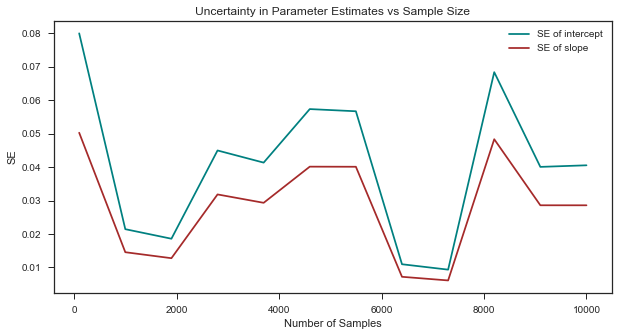

In [16]:
ses = np.array(ses)
    
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(samples, ses[:, 0], color='teal', label='SE of intercept')
ax.plot(samples, ses[:, 1], color='brown', label='SE of slope')

ax.set_xlabel('Number of Samples')
ax.set_ylabel('SE')
ax.set_title('Uncertainty in Parameter Estimates vs Sample Size')
ax.legend(loc='best')
plt.show()

---

## Residual Analysis

In residual analysis we want to check that the residuals are uncorrelated and normally distributed.

In [17]:
sdss_gal_df = pd.read_csv('sdss_gal.csv', low_memory=False)

In [18]:
sdss_gal_sample = sdss_gal_df.sample(n=1000, random_state=0)

y = sdss_gal_sample['redshift'].values
X = sdss_gal_sample['g-r'].values

X_train, X_test, y_train, y_test = train_test_split(X.reshape((len(X), 1)), y, test_size=0.33, random_state=0)

regression = LinearRegression(fit_intercept=True)
regression.fit(X_train, y_train)

regression_line = lambda x: regression.intercept_ + regression.coef_ * x
print 'The equation of the regression line is: {} + {} * x'.format(regression.intercept_, regression.coef_[0])

The equation of the regression line is: -0.0610563596323 + 0.304723028534 * x


We can also check the value of $R^2$ for both the training and test data sets.

In [20]:
train_R_sq = regression.score(X_train, y_train)
test_R_sq = regression.score(X_test, y_test)
print 'The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq)

The train R^2 is 0.499745586579, the test R^2 is 0.458760740679


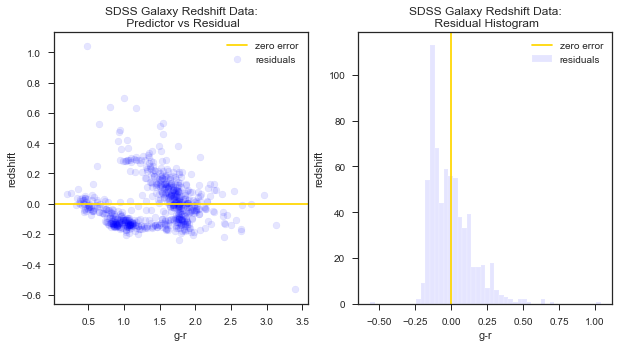

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

errors = y_train - regression.predict(X_train)
ax[0].scatter(X_train, errors, color='blue', alpha=0.1, label='residuals')
ax[0].axhline(y=0, color='gold', label='zero error')


ax[0].set_xlabel('g-r')
ax[0].set_ylabel('redshift')
ax[0].set_title('SDSS Galaxy Redshift Data:\n Predictor vs Residual')
ax[0].legend(loc='best')

ax[1].hist(errors, color='blue', alpha=0.1, label='residuals', bins=50, edgecolor='white', linewidth=2)
ax[1].axvline(x=0, color='gold', label='zero error')


ax[1].set_xlabel('g-r')
ax[1].set_ylabel('redshift')
ax[1].set_title('SDSS Galaxy Redshift Data:\n Residual Histogram')
ax[1].legend(loc='best')

plt.show()

---

## Multiple Linear Regression

Clearly redshift is not just a function of one color but of several so here we will look at fitting a linear model wiht multiple parameters.

In [21]:
sdss_gal_sample = sdss_gal_df.sample(n=1000, random_state=0)
#sdss_gal_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
#sdss_gal_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
msk = np.random.rand(len(sdss_gal_sample)) < 0.8
train = sdss_gal_sample[msk]
test = sdss_gal_sample[~msk]

y_train = train['redshift'].values
X_train = train[['g-r', 'r-i', 'i-z']].values

y_test = test['redshift'].values
X_test = test[['g-r', 'r-i', 'i-z']].values

In [22]:
multi_regression_model = LinearRegression(fit_intercept=True)
multi_regression_model.fit(X_train, y_train)

print 'The equation of the regression plane is: {} + {}^T . x'.format(multi_regression_model.intercept_, multi_regression_model.coef_)

The equation of the regression plane is: -0.118278181823 + [ 0.04995913  0.60563456 -0.07310092]^T . x


### 1. Train vs Test Error

Again we can look at various model diagnostics: first comparing the MSE and $R^2$ values for the training and test data sets:

In [23]:
train_MSE= np.mean((y_train - multi_regression_model.predict(X_train))**2)
test_MSE= np.mean((y_test - multi_regression_model.predict(X_test))**2)
print 'The train MSE is {}, the test MSE is {}'.format(train_MSE, test_MSE)

train_R_sq = multi_regression_model.score(X_train, y_train)
test_R_sq = multi_regression_model.score(X_test, y_test)
print 'The train R^2 is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq)

The train MSE is 0.00803744339786, the test MSE is 0.0120804080393
The train R^2 is 0.824913861836, the test R^2 is 0.760122581872


### 2. Uncertainty in the Model Parameter Estimates

And the uncertainties in each parameter estimate (u-g, g-r, r-i, i-z):

In [24]:
def find_regression_params(regression_model, samples, cols):
    sdss_gal_sample = sdss_gal_df.sample(n=samples)

    y = sdss_gal_sample['redshift'].values
    X = sdss_gal_sample[cols].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    regression_model.fit(X_train, y_train)
    
    return np.hstack((np.array([regression_model.intercept_]), regression_model.coef_))


def plot_hist_se(vals, bins, title, xlabel, ax):
    mean = vals.mean()
    std = vals.std()
    ax.hist(vals, bins=bins, color='blue', edgecolor='white', linewidth=1, alpha=0.2)
    ax.axvline(mean, color='red', label='mean = {0:.2f}'.format(mean))
    ax.axvline(mean - 2 * std, color='green', linestyle='--', label='std = {0:.2f}'.format(std))
    ax.axvline(mean + 2 * std, color='green', linestyle='--')

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend(loc='best')


    return ax

In [25]:
total_draws = 500
samples = 1000
regression_params = []

for i in range(total_draws):
    if i % 10 == 0:
        out = i * 1. / total_draws * 100
        sys.stdout.write("\r%d%%" % out)
        sys.stdout.flush()
        
    regression_params.append(find_regression_params(multi_regression_model, samples, ['g-r', 'r-i', 'i-z']))
    
sys.stdout.write("\r%d%%" % 100)
regression_params = np.array(regression_params)

100%

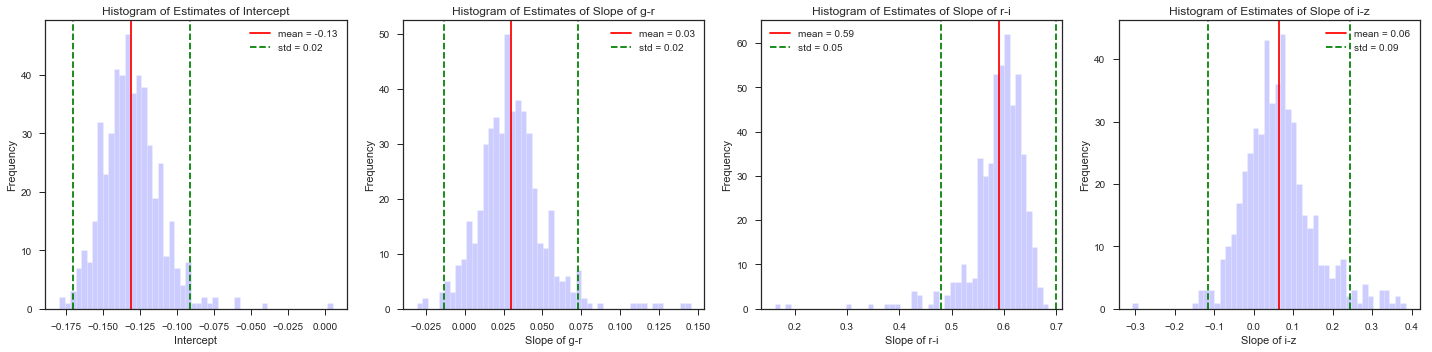

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0] = plot_hist_se(regression_params[:, 0], 50, 'Histogram of Estimates of Intercept', 'Intercept', ax[0])
ax[1] = plot_hist_se(regression_params[:, 1], 50, 'Histogram of Estimates of Slope of g-r', 'Slope of g-r', ax[1])
ax[2] = plot_hist_se(regression_params[:, 2], 50, 'Histogram of Estimates of Slope of r-i', 'Slope of r-i', ax[2])
ax[3] = plot_hist_se(regression_params[:, 3], 50, 'Histogram of Estimates of Slope of i-z', 'Slope of i-z', ax[3])

plt.tight_layout()
plt.show()

---

## Evaluating the Significance of Predictors

In [27]:
from statsmodels.tools import add_constant

predictors_multiple = ['g-r', 'r-i', 'i-z']
predictors_simple = ['g-r']

X_train_multi = add_constant(train[predictors_multiple].values)
X_test_multi = add_constant(test[predictors_multiple].values)

X_train_simple = add_constant(train[predictors_simple].values)
X_test_simple = add_constant(test[predictors_simple].values)

### 1. Measuring Significance Using F-Stat, p-Values

In [28]:
import statsmodels.api as sm
multi_regression_model = sm.OLS(y_train, X_train_multi).fit()
print 'F-stat:', multi_regression_model.fvalue
print 'p-values: {} (intercept), {} (g-r), {} (r-i), {} (i-z)'.format(*multi_regression_model.pvalues)

F-stat: 1268.95711135
p-values: 1.02412136235e-30 (intercept), 1.32043878503e-07 (g-r), 4.33015330103e-186 (r-i), 0.000478572181169 (i-z)


/Users/mjg/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 2. Measuring Significance Using AIC/BIC

In [29]:
print "AIC for ['g-r', 'r-i', 'i-z']:", multi_regression_model.aic
print "BIC for ['g-r', 'r-i', 'i-z']:", multi_regression_model.bic

AIC for ['g-r', 'r-i', 'i-z']: -1604.44293822
BIC for ['g-r', 'r-i', 'i-z']: -1585.64493686


In [30]:
simple_regression_model = sm.OLS(y_train, X_train_simple).fit()
print "AIC for ['g-r']:", simple_regression_model.aic
print "BIC for ['g-r']:", simple_regression_model.bic

AIC for ['g-r']: -749.128600308
BIC for ['g-r']: -739.729599627


### 3. Measuring Significance Using R^2

In [31]:
simple_model = LinearRegression(fit_intercept=False)
simple_model.fit(X_train_simple, y_train)

print "Simple Model: train R^2 = {}, test R^2 = {}".format(simple_model.score(X_train_simple, y_train), simple_model.score(X_test_simple, y_test))

multiple_model = LinearRegression(fit_intercept=False)
multiple_model.fit(X_train_multi, y_train)

print "Multiple Predictor Model: train R^2 = {}, test R^2 = {}".format(multiple_model.score(X_train_multi, y_train), multiple_model.score(X_test_multi, y_test))

Simple Model: train R^2 = 0.495510533769, test R^2 = 0.443654760099
Multiple Predictor Model: train R^2 = 0.824913861836, test R^2 = 0.760122581872


### 4. The Effect of Number of Predictors on R^2

In [32]:
multi_regression_model = LinearRegression(fit_intercept=True)

cols = ['u-g', 'g-r', 'r-i', 'i-z']
train_R_sq = []
test_R_sq = []
for i in range(1, len(cols) + 1):
    predictors = cols[:i]
    X_train = train[predictors].values
    X_test = test[predictors].values
    
    multi_regression_model.fit(X_train, y_train)
    
    train_R_sq.append(multi_regression_model.score(X_train, y_train))
    test_R_sq.append(multi_regression_model.score(X_test, y_test))

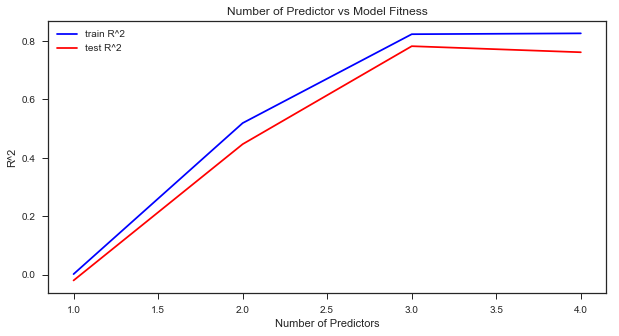

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(range(1, len(cols) + 1), train_R_sq, color='blue', label='train R^2')
ax.plot(range(1, len(cols) + 1), test_R_sq, color='red', label='test R^2')

ax.set_title('Number of Predictor vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

---

## Multiple Linear Regression with Interaction Terms

Now we'll consider multiple linear models with cross terms:

In [34]:
from sklearn.preprocessing import PolynomialFeatures

y_train = train['redshift'].values
X_train = train[['g-r', 'r-i', 'i-z']].values

y_test = test['redshift'].values
X_test = test[['g-r', 'r-i', 'i-z']].values

gen_cross_terms = PolynomialFeatures(degree=3, interaction_only=True)
cross_terms = gen_cross_terms.fit_transform(X_train)
X_train_with_cross = np.hstack((X_train, cross_terms))
cross_terms = gen_cross_terms.fit_transform(X_test)
X_test_with_cross = np.hstack((X_test, cross_terms))

Let's get fit statistics for the model with cross terms:

In [35]:
multi_regression_model = LinearRegression(fit_intercept=True)
multi_regression_model.fit(X_train_with_cross, y_train)

train_MSE = np.mean((y_train - multi_regression_model.predict(X_train_with_cross))**2)
test_MSE = np.mean((y_test - multi_regression_model.predict(X_test_with_cross))**2)
print 'The train MSE with interaction terms is {}, the test MSE is {}'.format(train_MSE, test_MSE)

train_R_sq = multi_regression_model.score(X_train_with_cross, y_train)
test_R_sq = multi_regression_model.score(X_test_with_cross, y_test)
print 'The train R^2 with interaction terms is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq)

The train MSE with interaction terms is 0.00596191392412, the test MSE is 0.0147494452823
The train R^2 with interaction terms is 0.870126801102, the test R^2 is 0.707124226133


And compare to models without the cross terms:

In [36]:
multi_regression_model.fit(X_train, y_train)

train_MSE = np.mean((y_train - multi_regression_model.predict(X_train))**2)
test_MSE = np.mean((y_test - multi_regression_model.predict(X_test))**2)
print 'The train MSE without interaction terms is {}, the test MSE is {}'.format(train_MSE, test_MSE)

train_R_sq = multi_regression_model.score(X_train, y_train)
test_R_sq = multi_regression_model.score(X_test, y_test)
print 'The train R^2 without interaction terms is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq)

The train MSE without interaction terms is 0.00803744339786, the test MSE is 0.0120804080393
The train R^2 without interaction terms is 0.824913861836, the test R^2 is 0.760122581872


---

## Polynomial Regression

In [37]:
y_train = train['redshift'].values
X_train = train[['g-r', 'r-i', 'i-z']].values

y_test = test['redshift'].values
X_test = test[['g-r', 'r-i', 'i-z']].values

gen_poly_terms = PolynomialFeatures(degree=2, interaction_only=False)
X_train_with_poly = gen_poly_terms.fit_transform(X_train)
X_test_with_poly = gen_poly_terms.fit_transform(X_test)

In [38]:
poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_with_poly, y_train)

train_MSE= np.mean((y_train - poly_regression_model.predict(X_train_with_poly))**2)
test_MSE= np.mean((y_test - poly_regression_model.predict(X_test_with_poly))**2)
print 'The train MSE for degree 2 poly model is {}, the test MSE is {}'.format(train_MSE, test_MSE)

train_R_sq = poly_regression_model.score(X_train_with_poly, y_train)
test_R_sq = poly_regression_model.score(X_test_with_poly, y_test)
print 'The train R^2 for degree 2 poly model is {}, the test R^2 is {}'.format(train_R_sq, test_R_sq)

The train MSE for degree 2 poly model is 0.00578648851031, the test MSE is 0.0122138882614
The train R^2 for degree 2 poly model is 0.873948234949, the test R^2 is 0.757472100948


### Effect of Polynomial Degree on Model Performance

In [39]:
from sklearn.preprocessing import MinMaxScaler

train_R_sq = []
test_R_sq = []
max_deg = 10

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

for d in range(max_deg + 1):

    out = d * 1. / max_deg * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()

    gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
    X_train_with_poly = gen_poly_terms.fit_transform(X_train)
    X_test_with_poly = gen_poly_terms.fit_transform(X_test)
    
    poly_regression_model = LinearRegression(fit_intercept=False)
    poly_regression_model.fit(X_train_with_poly, y_train)
    
    train_R_sq.append(poly_regression_model.score(X_train_with_poly, y_train))
    test_R_sq.append(poly_regression_model.score(X_test_with_poly, y_test))
    
sys.stdout.write("\r%d%%" % 100)

100%

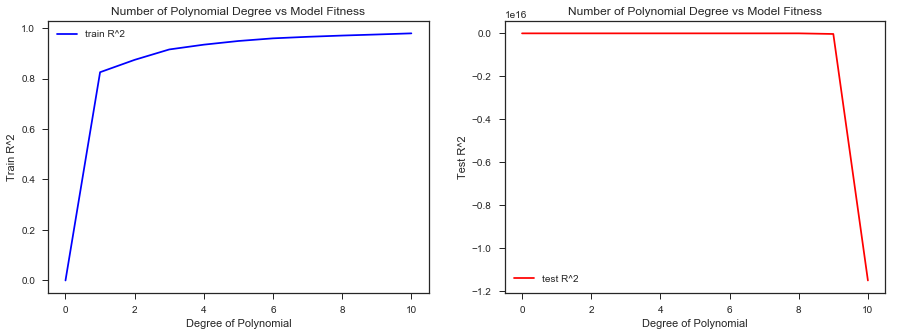

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(max_deg + 1), np.array(train_R_sq), color='blue', label='train R^2')

ax[0].set_title('Number of Polynomial Degree vs Model Fitness')
ax[0].set_xlabel('Degree of Polynomial')
ax[0].set_ylabel('Train R^2')
ax[0].legend(loc='best')

ax[1].plot(range(max_deg + 1), test_R_sq, color='red', label='test R^2')

ax[1].set_title('Number of Polynomial Degree vs Model Fitness')
ax[1].set_xlabel('Degree of Polynomial')
ax[1].set_ylabel('Test R^2')
ax[1].legend(loc='best')


plt.show()

---

## Examples of Overfitting

We're going to overload the train_test_split method to return a number of samples and also a validation set if requested:

In [41]:
sdss_gal_df = pd.read_csv('sdss_gal.csv', low_memory=False)

def train_test_split(df, n_samples, validation=False):
    if validation:
        sdss_gal_sample = df.sample(n=n_samples)

        msk = np.random.rand(len(sdss_gal_sample)) < 0.8
        non_test = sdss_gal_sample[msk]
        test = sdss_gal_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        sdss_gal_sample = df.sample(n=n_samples)

        msk = np.random.rand(len(sdss_gal_sample)) < 0.8
        train = sdss_gal_sample[msk]
        test = sdss_gal_sample[~msk]

        return train, test

---

### Too Many Features

The SDSS galaxy redshift data set only has four features but for a higher dimensional data set may be more prone to this effect:

In [42]:
train, test = train_test_split(sdss_gal_df, 50)
y_train = train['redshift'].values
y_test = test['redshift'].values

multi_regression_model = LinearRegression(fit_intercept=True)

cols = ['u-g', 'g-r', 'r-i', 'i-z']

train_R_sq = []
test_R_sq = []
for i in range(1, len(cols) + 1):
    predictors = cols[:i]
    X_train = train[predictors].values
    X_test = test[predictors].values
    
    multi_regression_model.fit(X_train, y_train)
    
    train_R_sq.append(multi_regression_model.score(X_train, y_train))
    test_R_sq.append(multi_regression_model.score(X_test, y_test))

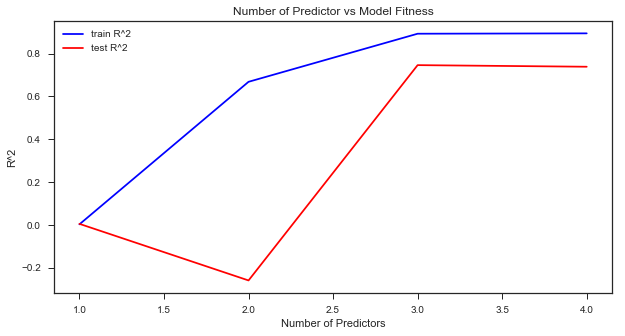

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(range(1, len(cols) + 1), train_R_sq, color='blue', label='train R^2')
ax.plot(range(1, len(cols) + 1), test_R_sq, color='red', label='test R^2')

ax.set_title('Number of Predictor vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

### Degree Too High

We've already seen this for the polynomial with multiple predictors but we can demonstrate it even with just one predictor:

In [44]:
train, test = train_test_split(sdss_gal_df, 5000)
y_train = train['redshift'].values
y_test = test['redshift'].values

poly_regression_model = LinearRegression(fit_intercept=False, normalize=True)

X_train = train[['g-r']].values.reshape((len(train), 1))
X_test = test[['g-r']].values.reshape((len(test), 1))

train_R_sq = []
test_R_sq = []
max_deg = 30

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

for d in range(1, max_deg):

    gen_poly_terms = PolynomialFeatures(degree=d)
    X_train_poly = gen_poly_terms.fit_transform(X_train)
    X_test_poly = gen_poly_terms.fit_transform(X_test)
    
    poly_regression_model.fit(X_train_poly, y_train)
    
    train_R_sq.append(poly_regression_model.score(X_train_poly, y_train))
    test_R_sq.append(poly_regression_model.score(X_test_poly, y_test))


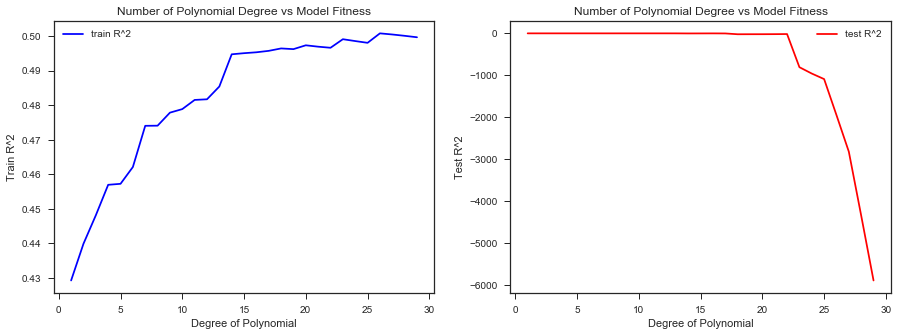

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(1, max_deg), np.array(train_R_sq), color='blue', label='train R^2')

ax[0].set_title('Number of Polynomial Degree vs Model Fitness')
ax[0].set_xlabel('Degree of Polynomial')
ax[0].set_ylabel('Train R^2')
ax[0].legend(loc='best')

ax[1].plot(range(1, max_deg), test_R_sq, color='red', label='test R^2')

ax[1].set_title('Number of Polynomial Degree vs Model Fitness')
ax[1].set_xlabel('Degree of Polynomial')
ax[1].set_ylabel('Test R^2')
ax[1].legend(loc='best')


plt.show()

### Parameters are Too Extreme

In [46]:
X_train = np.linspace(0, 40, 20)
y_train = np.hstack((2 * X_train + 10,  np.array([(2 * 45 + 10) * 10000])))
X_train = np.hstack((X_train, np.array([45])))

regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train.reshape((len(X_train), 1)), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

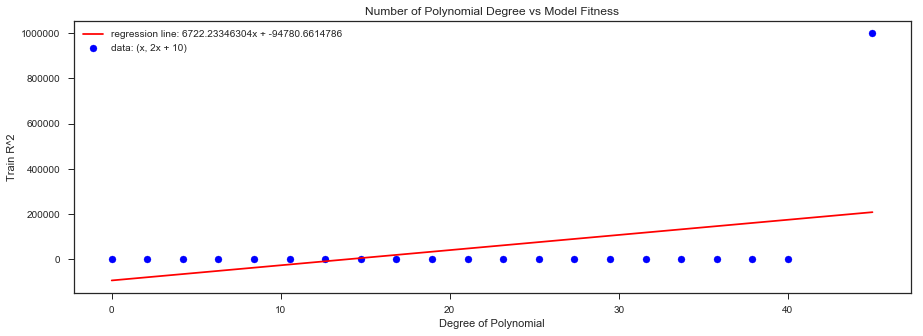

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.scatter(X_train, y_train, color='blue', label='data: (x, 2x + 10)')
ax.plot(X_train, regression_model.intercept_ + regression_model.coef_[0] * X_train, color='red', label='regression line: {}x + {}'.format(regression_model.coef_[0], regression_model.intercept_), )

ax.set_title('Number of Polynomial Degree vs Model Fitness')
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('Train R^2')
ax.legend(loc='best')
plt.show()

---

## Cross Validation For Selecting Polynomial Model Degree

We're going to use k-fold cross validation to determine the degree of the best polynomial for our data:

In [48]:
from sklearn.model_selection import KFold

non_test, test = train_test_split(sdss_gal_df, 5000)
regression_model = LinearRegression(fit_intercept=False)
min_max_scaler = MinMaxScaler()

y_non_test = non_test['redshift'].values
y_test = test['redshift'].values

X_non_test = non_test['g-r'].values.reshape((len(non_test), 1))
X_test = test['g-r'].values.reshape((len(test), 1))

X_non_test = min_max_scaler.fit_transform(X_non_test)
X_test = min_max_scaler.fit_transform(X_test)

kf = KFold(n_splits=10)

x_val_scores = []

for d in range(1, 20):

    gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
    X_non_test_poly = gen_poly_terms.fit_transform(X_non_test)

    validation_R_sqs = []
    for train_index, val_index in kf.split(X_non_test_poly):
        X_train, X_val = X_non_test_poly[train_index], X_non_test_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        regression_model.fit(X_train, y_train)
        validation_R_sqs.append(regression_model.score(X_val, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))

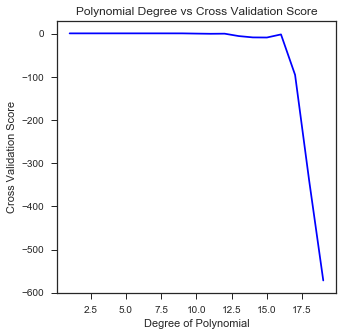

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 20), x_val_scores, color='blue')

ax.set_title('Polynomial Degree vs Cross Validation Score')
ax.set_xlabel('Degree of Polynomial')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [50]:
best_degree = range(1, 20)[np.argmax(x_val_scores)]

gen_poly_terms = PolynomialFeatures(degree=d, interaction_only=False)
X_non_test_poly = gen_poly_terms.fit_transform(X_non_test)
X_test_poly = gen_poly_terms.fit_transform(X_test)

regression_model.fit(X_non_test_poly, y_non_test)
test_R_sq = (regression_model.score(X_test_poly, y_test))

print 'best degree is:', best_degree
print 'the test R^2 for a degree {} model is: {}'.format(best_degree, test_R_sq)

best degree is: 7
the test R^2 for a degree 7 model is: 0.310278377147


---

## Comparing Ridge and LASSO Regression

In [60]:
from sklearn.linear_model import Ridge, Lasso

train, validation, test = train_test_split(sdss_gal_df, 5000, validation=True)

y_train = train['redshift'].values
y_val = validation['redshift'].values
y_test = test['redshift'].values

regression_model = LinearRegression(fit_intercept=True)

all_predictors = ['u-g', 'g-r', 'r-i', 'i-z']

### 2. Ridge Regression

In [61]:
X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_test = test[all_predictors].values

ridge_regression = Ridge(alpha=1.0, fit_intercept=True)
ridge_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print 'Ridge regression model:\n {} + {}^T . x'.format(ridge_regression.intercept_, ridge_regression.coef_)

Ridge regression model:
 -0.107296556217 + [-0.01089472  0.03796666  0.57678514  0.05883413]^T . x


In [62]:
print 'Train R^2: {}, test R^2: {}'.format(ridge_regression.score(np.vstack((X_train, X_val)), 
                                                                  np.hstack((y_train, y_val))), 
                                           ridge_regression.score(X_test, y_test))

Train R^2: 0.788223837824, test R^2: 0.807231240996


### 3. LASSO Regression

In [63]:
lasso_regression = Lasso(alpha=1.0, fit_intercept=True)
lasso_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print 'Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_)

Lasso regression model:
 0.373451620107 + [-0.  0.  0.  0.]^T . x


In [64]:
print 'Train R^2: {}, test R^2: {}'.format(lasso_regression.score(np.vstack((X_train, X_val)), 
                                                                  np.hstack((y_train, y_val))), 
                                           lasso_regression.score(X_test, y_test))

Train R^2: 0.0, test R^2: -0.00172620882533


---

## The Effect of the Regularization Parameter

In [65]:
reg_params = np.hstack((10.**np.arange(-7, 0), 10**np.arange(0, 4) + 0.01))

### 1. Ridge Regression

In [66]:
train_R_sq = []
test_R_sq = []

for reg in reg_params:
    ridge_regression = Ridge(alpha=reg, fit_intercept=True)
    ridge_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
    
    train_R_sq.append(ridge_regression.score(np.vstack((X_train, X_val)), np.hstack((y_train, y_val))))
    test_R_sq.append(ridge_regression.score(X_test, y_test))

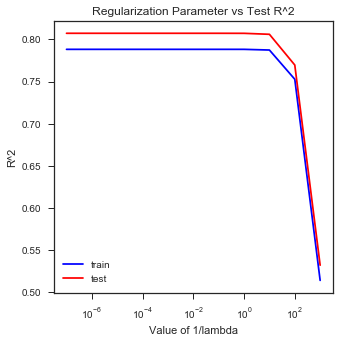

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='red', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Value of 1/lambda')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

### 2. LASSO Regression

In [68]:
train_R_sq = []
test_R_sq = []

for reg in reg_params:
    lasso_regression = Lasso(alpha=reg, fit_intercept=True)
    lasso_regression.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))
    
    train_R_sq.append(lasso_regression.score(np.vstack((X_train, X_val)), np.hstack((y_train, y_val))))
    test_R_sq.append(lasso_regression.score(X_test, y_test))

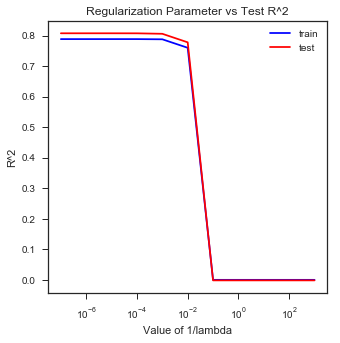

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, train_R_sq, color='blue', label='train')
ax.plot(reg_params, test_R_sq, color='red', label='test')

ax.set_xscale('log')
ax.set_title('Regularization Parameter vs Test R^2')
ax.set_xlabel('Value of 1/lambda')
ax.set_ylabel('R^2')
ax.legend(loc='best')

plt.show()

---

## Cross Validation: Selecting the Regularization Parameter

In [70]:
X_non_test = np.vstack((X_train, X_val))
y_non_test = np.hstack((y_train, y_val))


kf = KFold(n_splits=10)

x_val_scores = []

for reg in reg_params:
    ridge_regression = Ridge(alpha=reg, fit_intercept=True)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_non_test):
        X_train, X_val = X_non_test[train_index], X_non_test[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        
        ridge_regression.fit(X_train, y_train)
        validation_R_sqs.append(ridge_regression.score(X_val, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))

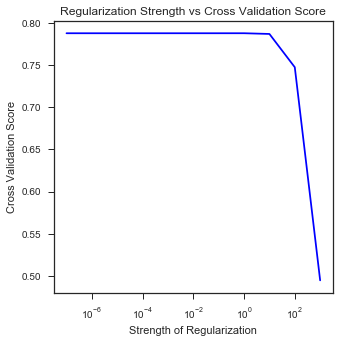

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(reg_params, x_val_scores, color='blue')

ax.set_xscale('log')
ax.set_title('Regularization Strength vs Cross Validation Score')
ax.set_xlabel('Strength of Regularization')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [72]:
best_alpha = reg_params[np.argmax(x_val_scores)]

ridge_regression = Ridge(alpha=best_alpha, fit_intercept=True)
ridge_regression.fit(X_non_test, y_non_test)
test_R_sq = (ridge_regression.score(X_test, y_test))

print 'best regularization param is:', best_alpha
print 'the test R^2 for ridge regression with alpha = {} is: {}'.format(best_alpha, test_R_sq)

best regularization param is: 1.01
the test R^2 for ridge regression with alpha = 1.01 is: 0.807230648634


---

## Bias-Variance Tradeoff

Consider a regression model that fits perfectly the *training data* (e.g. high order polynomial or small $h$). This complex model will have a high variance when regressing new data. On the other hand, a model too simple will have very low variance, but at the same time it will have a high bias. Furthermore, there is a tradeoff between bias and variance in terms of the MSE of the model:

$\mathrm{MSE}(x) = \mathbb{E}(f(x) - \hat{f}(x)) = \mathrm{bias}_x^2 + \mathrm{variance}_x + \sigma^2$, where

$\mathrm{bias}_x = \mathbb{E}(\hat{f}(x))- f(x)$

$\mathrm{variance}_x = \mathrm{Var}(\hat{f}(x)) = \mathbb{E}(\hat{f}(x) - \mathbb{E}(\hat{f}(x)))$

$\sigma$ = standard deviation of the noise.

<img src = http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png/>


In [ ]:
x = np.arange(0, 2*np.pi, 0.01)
y = np.cos(2*x)

sigma_noise = 0.1
N = 5
pl.clf()

pl.plot(x, y, "k")
colors = ['r', 'b', 'g', 'c', "m", "y"]
for i in range(N):
    x_data = np.random.random(10)*2*np.pi
    y_data = np.cos(2*x_data) + np.random.normal(scale = sigma_noise, size = 10)

    p1 = np.polyfit(x_data, y_data, 0)
    p1 = np.poly1d (p1)
    y1 = p1(x)

    pl.plot(x_data, y_data, "o" + colors[i])
    pl.plot (x, y1, colors[i])
pl.title ("0 order poly: high bias, low variance")
pl.ylim ([-3, 3])    
pl.show()

pl.clf()
pl.plot(x, y, "k")
for i in range(N):
    x_data = np.random.random(10)*2*np.pi
    y_data = np.cos(2*x_data) + np.random.normal(scale = sigma_noise, size = 10)

    p10 = np.polyfit(x_data, y_data, 8)
    p10 = np.poly1d (p10)
    y10 = p10(x)

    pl.plot(x_data, y_data, "o" + colors[i])
    pl.plot (x, y10, colors[i])
pl.title ("9th order poly: low bias, high variance")
pl.ylim ([-3, 3])
pl.show()

In general, the more biased our model is, the lowest the variance, and vice versa. The good news is that we can balance variance and bias using the RMSE over a _test set_. This is the same concept of cross-validation used in classification.

